In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp
from scipy import integrate
from scipy.optimize import root
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
import pandas as pd
import time

fig_path = 'cosmo_report/Figures/'

# Part 1: Compute and Plot Relevant Physical Quantities

In [4]:
class Cosmology:
    def __init__(self, omega_m, omega_Lambda, omega_r, current_hubble_param, current_reduced_hubble_param, speed_of_light):
        self.m = omega_m
        self.Lambda = omega_Lambda
        self.r = omega_r
        self.H_0 = current_hubble_param #km/s/Mpc
        self.h_0 = current_reduced_hubble_param #km/s/Mpc
        self.c = speed_of_light #km/s
        
cosmo = Cosmology(0.3, 0.7, 0, 70, 0.7, 3e5)

meter = 3.24078e-23 #Mpc
M_sol = 1.989e30 #kg
kg = (M_sol)**(-1) #M_sol
G = 6.67408e-11 #m^3/kg/s^2
radian = 2.06265e5 #arcseconds
k_B = 1.38e-23 #m^2kg/s^2/K

#Converting constants into differnet units
s_per_yr = 24*365*3600
H_0_units = cosmo.H_0 * 1e3 * meter #s^-1
H_0_years = H_0_units*s_per_yr
G_units = G * ((meter)**3/(kg)) #Mpc^3/M_sol/s^2
G_kpc = G_units*(1e3)**3 #kpc^3/M_sol/s^2
k_B_units = 1.38e-23*((meter*1e3)**2) #kpc^2kg/s^2/K
k_B_ergs = 1.38064852e-16 #erg/K

mu = 0.57 #Mean molecular weight

rho_crit_0 = (3/(8*math.pi*G_units))*(H_0_units)**2
rho_m = rho_crit_0 * cosmo.m

delta_crit_0 = 1.69

m_p = 1.67e-27 #mass of proton in kg


In [13]:
#==========DEFINING FUNCTIONS===========#

#Hubble Constant
def H(z):
    return cosmo.H_0*math.sqrt(cosmo.m*(1+z)**3 + cosmo.r*(1+z)**4 + cosmo.Lambda) 

#Hubble Distance (Mpc)
def d_H(z):
    return cosmo.c/H(z)

#Comoving Distance (Mpc)
def r_c(z):
    return integrate.quad(d_H,0,z)[0]

#Angular Diameter Distances
def d_A(z):
    return r_c(z)/(1+z)

#Scale factor: 
def a(z):
    return 1/(1+z)

#Function f:
def f(a):
    return cosmo.Lambda*a**3 + cosmo.r*a + cosmo.m

#Growth Factor
def D(a):
    return math.sqrt(f(a)/a**3)*integrate.quad(lambda a: (a/f(a))**1.5,0,a)[0]

#Normalisation condition for Growth Factor
D_norm = D(1)

#Normalised Growth Factor
def D_n(a): 
    return (1/D_norm)*D(a)

In [14]:
#==========DEFINING FUNCTIONS===========#
#Omega_m^z
def omega_m_z(z):
    return (cosmo.m*(1+z)**3)/(cosmo.m*(1+z)**3 + cosmo.Lambda + cosmo.r*(1+z)**2)

#Function 'q' at z=0
def q(k):
    return (k)/(omega_m_z(0)*(cosmo.h_0**2))

#Temperature at z=0
def Temp(k):
    return ((math.log(1+2.34*q(k)))/(2.34*q(k)))*(1+3.89*q(k)+(16.1*q(k))**2 + (5.46*q(k))**3 + (6.71*q(k))**4)**(-0.25)

#Power Spectrum at z=0
def P(k):
    n=1
    return (k**n)*(Temp(k))**2    

#Radius as a function of mass at current critical density
def R(M):
    return ((3*M)/(4*math.pi*rho_crit_0))**(1/3)

#j_1(x)
def j_1(x):
    return (math.sin(x)-x*math.cos(x))/(x)**2

#Variance
def var(R):
    return (1/(2*(math.pi)**2))*(integrate.quad(lambda k: (k**2)*P(k)*((3*j_1(k*R))/(k*R))**2, 0, np.inf)[0])

#Sigma (Std. Deviation)
def sigma(R):
    return math.sqrt(var(R))

sigma_8_norm = 0.8/(sigma(8/0.7))

#Normalised sigma
def sigma_norm(R): 
    return sigma_8_norm*sigma(R)

#Normalised sigma as a function of mass
def sigma_norm_m(M):
    return sigma_norm(R(M))

## (d) Press-Schechter Mass Function

Press-Schechter mass function of DM halos (at a range of redshifts)

In [15]:
#==========DEFINING FUNCTIONS===========#

#Differentiate log(sigma(m)) w.r.t mass
def logsigma_dm(M):
    return (math.log(sigma_norm_m(1.1*M))-math.log(sigma_norm_m(M)))/(1.1*M-M)

#Critical density
def delta_crit(z):
    return delta_crit_0/D_n(a(z))

#Critical nu
def nu_crit(M,z):
    return delta_crit(z)/sigma_norm_m(M)

#Press-Schechter Mass Function (PSMF)
def psmf(M,z):
    return -math.sqrt(2/math.pi)*(rho_m/M)*logsigma_dm(M)*nu_crit(M,z)*math.exp(-(nu_crit(M,z))**2/2)

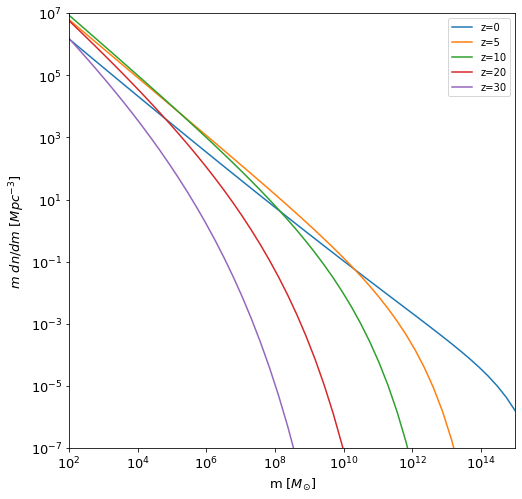

In [16]:
#==========COMPUTING PRESS-SCHECHTER MASS FUNCTION=========#

plt.figure(figsize=(8,8))

z_range_var = np.array([0,5,10,20,30])

M_max = 15

M_range = np.logspace(2,M_max)

R_range = [R(M) for M in M_range]

sigma_plot = [sigma_norm(R) for R in R_range]

for z in z_range_var: 
    plot_psmf = []
    for M in M_range:
        plot_psmf.append(M*psmf(M,z))
    plt.plot(M_range, plot_psmf, label=f"z={z}")

plt.xscale("log")
plt.yscale("log")
plt.ylabel(r'$m$ $dn/dm$ [$Mpc^{-3}$]',fontsize=13)
plt.xlabel('m [$M_{\odot}$]',fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
#plt.title("Press-Schechter Halo Mass Functions at Redshift, z")
plt.ylim(1e-7, 1e7)
plt.xlim(1e2, 1e15)
plt.legend()
plt.savefig(fig_path+'psmf.png')

# Question 2: Halos of mass M at redshift z

## (a) Virial Radii

### Dark Matter Halos

In [21]:
#==========DEFINING FUNCTIONS===========#

#Definition of 'd'
def d(z):
    return omega_m_z(z)-1

#Critical Overdensity
def Delta_crit(z):
    return 18*(math.pi)**2 + 82*d(z) - 39*(d(z))**2

#Virial radius of DM halo in LambdaCDM (kpc)
def r_halo(M,z):
    return 0.784*(((M*omega_m_z(z)*cosmo.h_0*18*(math.pi)**2)/(1e8*cosmo.m*Delta_crit(z)))**(1/3))*(10/(1+z))*(1/cosmo.h_0)


In [22]:
#==========DEFINING FUNCTIONS===========#
#Radius of Galaxy Disk
def r_disk(M,z):
    return r_halo(M,z)/40

In [23]:
# #==========DEFINING FUNCTIONS===========#
# #Angular Extent of halo (radians)
# def ang_halo_rad(M,z): 
#     return 2*(r_halo(M,z)*1e-3/d_A(z))

# #Angular Extent of halo (arcsec)
# def ang_halo(M,z):
#     return radian*ang_halo_rad(M,z)

In [24]:
# #==========DEFINING FUNCTIONS===========#
# #Angular Extent of disk (radians)
# def ang_disk_rad(M,z): 
#     return 2*(r_disk(M,z)*1e-3/d_A(z))

# #Angular Extent of disk (arcsec)
# def ang_disk(M,z):
#     return radian*ang_disk_rad(M,z)

# Question 3: Minimum Mass of a Galaxy

In [25]:
#==========DEFINING FUNCTIONS===========#
#Circular Velocity
def V_c_squared(M,z):
    return (G_kpc*M)/r_halo(M,z)

#Virial Temprature
def T_vir(M,z):
    return (mu*m_p*V_c_squared(M,z))/(2*k_B_units)

T_vir_min = 1e4 

def find_Mmin(M,z):
    return T_vir(M,z)-T_vir_min

def M_halo_min(z):
    return root(find_Mmin,1e7,args=z).x[0]

#Minimum Mass of a galaxy
#def M_on_r_halo(z):
#    return (2*k_B_units*1e4)/(mu*m_p*G_kpc)
    #return ((10**4/(cosmo.h_0**(2/3)))*(10**12)**(2/3)*(3.7e5*(1+z))**(-1))**(3/2)
    
#def M_halo_min(z):
#    return (M_on_r_halo(z)*0.784*(((omega_m_z(z)*cosmo.h_0*18*(math.pi)**2)/(1e8*cosmo.m*Delta_crit(z)))**(1/3))*(10/(1+z))*(1/cosmo.h_0))**(3/2)


In [39]:
#Circular Velocity
def V_c_squared(M,z):
    return (G_kpc*M)/r_halo(M,z)

#Virial Temprature
def T_vir(M,z):
    return (mu*m_p*V_c_squared(M,z))/(2*k_B_units)

T_vir_min = 1e4 

def find_Mmin(M,z):
    return T_vir(M,z)-T_vir_min

def M_halo_min(z):
    return root(find_Mmin,1e7,args=z).x[0]

def cdtdz(z): 
    return (d_H(z)*a(z))

## Plotting Minimum Galaxy Mass against Redshift

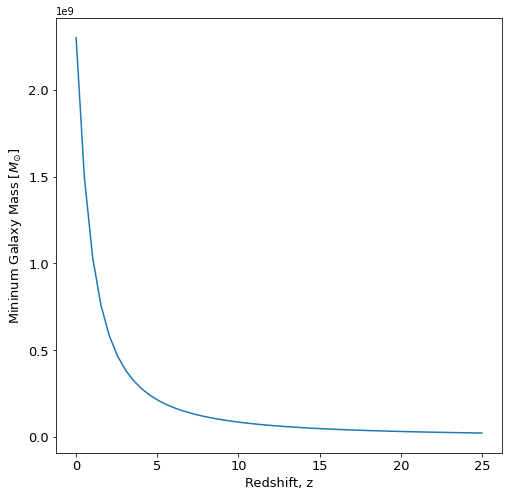

In [40]:
#==========MINIMUM GALAXY MASS AS A FUNCTION OF REDSHIFT===========#
plt.figure(figsize=(8,8))

plot_M_min = []

z_range_csec = np.linspace(0,25,50)

for z in z_range_csec:
    plot_M_min.append(M_halo_min(z))

plt.plot(z_range_csec, plot_M_min)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Redshift, z', fontsize=13)
plt.ylabel('Mininum Galaxy Mass [$M_{\odot}$]', fontsize=13)
#plt.title('Minimum Galaxy Mass vs. Redshift, z')
plt.savefig(fig_path+'mass_min.png')
#plt.yscale('log')

# Question 5: Cooling Function

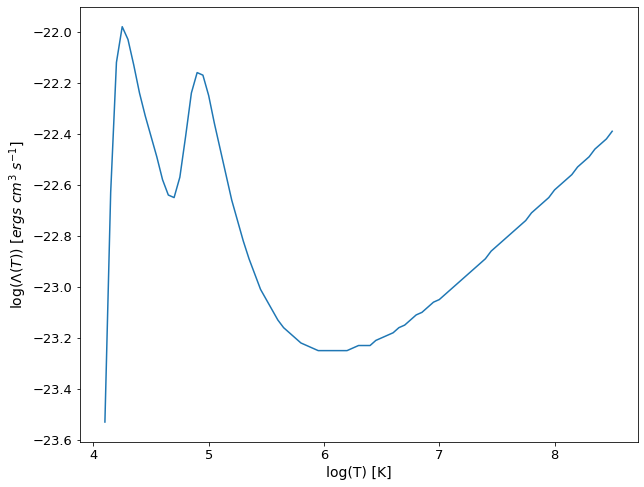

In [41]:
coolfnc_data = pd.read_csv('cooling_fnc_data.csv')

T_range = pd.Series.tolist(coolfnc_data['log(T)'])
ne_range = pd.Series.tolist(coolfnc_data['ne'])
Lambda_range = pd.Series.tolist(coolfnc_data['log(lambda_net)'])
rho_range = pd.Series.tolist(coolfnc_data['rho24'])
tcool_range = pd.Series.tolist(coolfnc_data['log(taucool)'])
U_range = pd.Series.tolist(coolfnc_data['log(U)'])

plt.figure(figsize=(10,8))
plt.plot(T_range[2:], Lambda_range[2:])
plt.xlabel('log(T) [K]',fontsize=14)
plt.ylabel(r'log($\Lambda (T)$) [$ergs$ $cm^3$ $s^{-1}$]',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig(fig_path+'cool_fnc.png')

## (a) Cooling Time as a function of mass at z=0

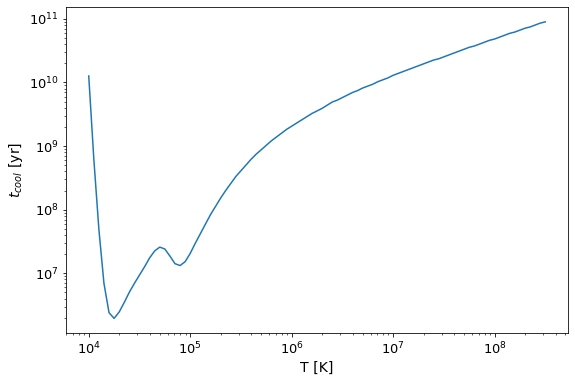

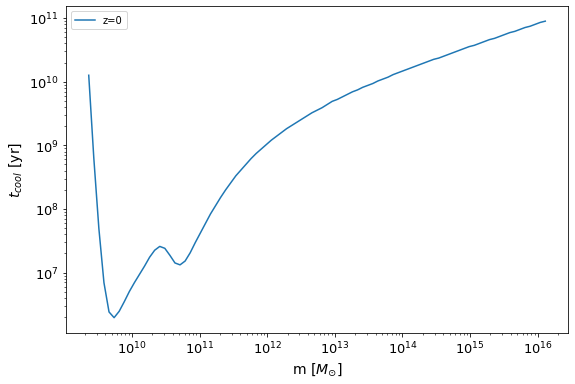

In [42]:
def find_M(M,T,z):
    return T_vir(M,z)- 10**T

def M_halo(T,z):
    return fsolve(lambda M: find_M(M,T,z),1e8)[0]


ne = 1e-3

def t_cool(T, Lambda):
    return 1.5*((k_B_ergs*(10**T))/(0.57*(ne)*(10**Lambda)))


t_cool_plot = []
M_cool_plot = []
for index in range(len(T_range)):
    cooling_time_secs = t_cool(T_range[index], Lambda_range[index]) 
    t_cool_plot.append(cooling_time_secs/s_per_yr)
    M_cool_plot.append(M_halo(T_range[index],0))
    
    
plt.figure(1, figsize=(9,6))
plt.plot([10**T for T in T_range], t_cool_plot)
plt.xlabel('T [K]', fontsize=14)
plt.ylabel(r'$t_{cool}$ [yr]', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')
plt.yscale('log')
plt.savefig(fig_path+'tcool.png')

plt.figure(2, figsize=(9,6))
plt.plot(M_cool_plot, t_cool_plot, label=f"z={0}")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'm [$M_{\odot}$]', fontsize=14)
plt.ylabel(r'$t_{cool}$ [yr]', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.savefig(fig_path+'tcool_mass.png')


## (b) Collapse Redshift as a function of halo mass 
## (c) Modified Press-Schechter Mass Function

Here we have assumed Einstein de Sitter Universe hence Equation 10.12 in lectures applies

In [43]:
def z_col(tcool,z):
    return ((((1+z)**(-3/2))-(1.5*tcool*H_0_years))**(-2/3)-1)

def modified_delta_crit(zcol):
    return 1.69*(1+zcol)

#Critical nu
def modified_nu_crit(M,zcol):
    return modified_delta_crit(zcol)/sigma_norm_m(M)

#Press-Schechter Mass Function (PSMF)
def modified_psmf(M,zcol,z):
    return -math.sqrt(2/math.pi)*(rho_m/M)*logsigma_dm(M)*modified_nu_crit(M,zcol)*math.exp(-(modified_nu_crit(M,zcol))**2/2)



<ipython-input-43-8d31ba3f871d>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((((1+z)**(-3/2))-(1.5*tcool*H_0_years))**(-2/3)-1)
<ipython-input-43-8d31ba3f871d>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((((1+z)**(-3/2))-(1.5*tcool*H_0_years))**(-2/3)-1)
<ipython-input-43-8d31ba3f871d>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((((1+z)**(-3/2))-(1.5*tcool*H_0_years))**(-2/3)-1)
<ipython-input-43-8d31ba3f871d>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((((1+z)**(-3/2))-(1.5*tcool*H_0_years))**(-2/3)-1)
<ipython-input-21-2549d1920058>:13: RuntimeWarning: invalid value encountered in power
  return 0.784*(((M*omega_m_z(z)*cosmo.h_0*18*(math.pi)**2)/(1e8*cosmo.m*Delta_crit(z)))**(1/3))*(10/(1+z))*(1/cosmo.h_0)
/Users/leeyishuen/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by th

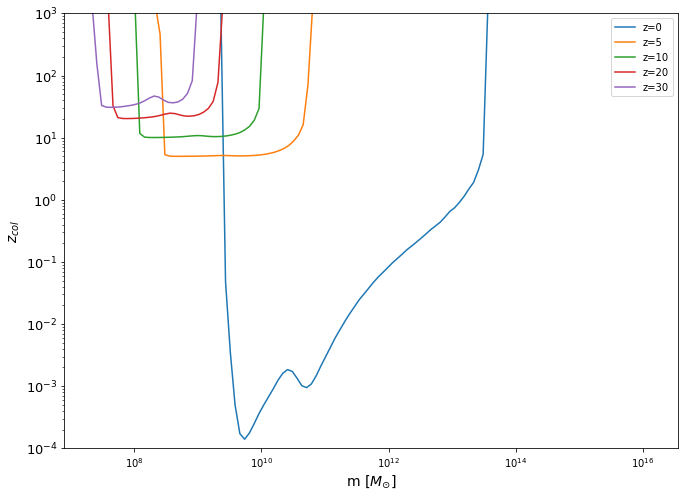

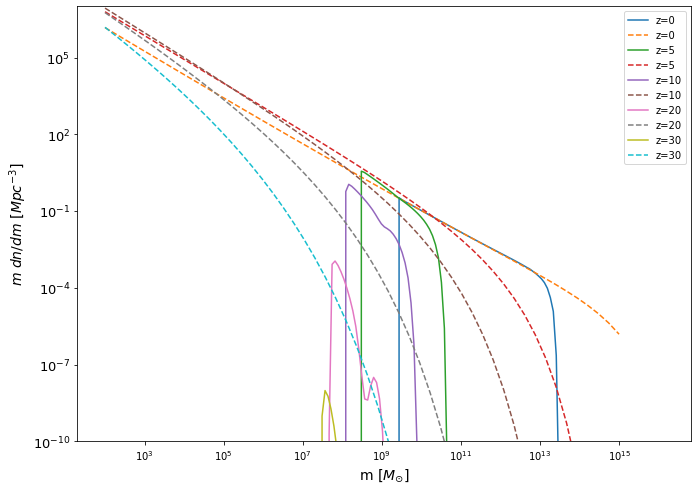

In [44]:

for z in z_range_var:
    t_cool_plot = []
    #M_cool_plot = []
    z_col_init = []
    M_cool_init_z = []
    modified_psmf_plot = []
    original_psmf_plot = []
    for index in range(len(T_range)):
        cooling_time_secs = t_cool(T_range[index], Lambda_range[index]) 
        t_cool_plot.append(cooling_time_secs/s_per_yr)
        M_cool_init_z.append(M_halo(T_range[index],z))
    for i in range(len(T_range)):
        z_col_init.append(z_col(t_cool_plot[i],z))
    for i in range(len(z_col_init)):
        if np.isnan(z_col_init[i])==True or np.imag(z_col_init[i])!=0:
            z_col_init[i]=1380
    plt.figure(1, figsize=(11,8))
    plt.plot(M_cool_init_z, z_col_init, label=f"z={z}")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'm [$M_{\odot}$]', fontsize=14)
    plt.ylabel(r'$z_{col}$', fontsize=14)
    plt.yticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylim(1e-4, 1e3)
    plt.legend()
    plt.savefig(fig_path+'zcol.png')
    for k in range(len(z_col_init)):
        modified_psmf_plot.append(M_cool_init_z[k]*modified_psmf(M_cool_init_z[k],z_col_init[k],z))
    for M in M_range:
        original_psmf_plot.append(M*psmf(M,z))
    plt.figure(2, figsize=(11,8))
    plt.plot(M_cool_init_z,modified_psmf_plot,label=f"z={z}")
    plt.plot(M_range,original_psmf_plot,linestyle='--',label=f"z={z}")
    plt.ylim(1e-10, 1e7)
    plt.xscale('log')
    plt.yscale('log')
    plt.yticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel(r'm [$M_{\odot}$]', fontsize=14)
    plt.ylabel(r'$m$ $dn/dm$ [$Mpc^{-3}$]',fontsize=14)
    plt.legend()
    plt.savefig(fig_path+'modified_psmf.png')

# plt.plot(M_cool_init_z, z_col_init)
# plt.ylim(1e-3, 1e2)
# plt.xscale('log')
# plt.yscale('log')